#### Next steps:
1. Test this out on an art_simulated sample from E. lenta
2. Start with sample-resolved analysis, then read level
    * Count all the kmers in the sample
    * Calculate the resultant k-mer matrix
    * Hsum, vsum, ktypes, singletons, accessory, number of core reads, estimated abundance, sample wide things.
    * See if you can recover something novel compared to prior
    * Try to run on an unrelated bacteria and compare the results
    * Retain the k-mer to gene database and see if that also comes in handy later
3. So much new data lol

# Building Strainr with pangenomics

In [86]:
import pathlib
import pickle
from collections import defaultdict, Counter
import collections
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import random
import inspect

sns.set_theme()
sns.set_context('poster')

Match strain names to accession

In [2]:
def retrieve_names(gbff_file):
    """
    Input: The list of all the relevant gbff files for the database

    Process: Go into each genbank flat file (GBFF) to obtain the strain name, 
    then format it and assign the name to the genome accession [GCA_|GCF_]

    Returns: A dict mapping each accession to a strain name
    
    
    """
    accession_to_strain = {}

    for gbff in gbff_file:
        with open(gbff) as fi:
            for line in fi:
                words = line.split()

                # if line exists and matches first term
                if words and words[0] == 'DEFINITION': 

                    # Generate strain name
                    strain = ' '.join(words[3:6]) # Clean up the strain name
                    if strain.startswith('strain '): 
                        strain = ' '.join(strain.split()[1:])

                    strain = ''.join(strain.split(',')[0])
                    
                    # Get accession file
                    accession = '_'.join(gbff.name.split('_')[:2])

                    # Match name to file
                    accession_to_strain[accession] = strain

    return accession_to_strain

gbffs = pathlib.Path("/hdd/scratch_files/elenta_genomes/genbank/bacteria").glob('*/*gbff')
accession_to_strain =  retrieve_names(gbffs)

Generate kmers from pangenome gene sequences

In [3]:

def kmer_gene_table(sequences):
    """
    Input: Fasta file of all pangenomic gene sequences

    Procedure: Generate kmers, and create a database linking each k-mer with gene(s)
        In case of multiple genes, k-mer maps to list of genes, which are then given
        separate rows, and will later be merged for strain presence/absence

    Output: A nonunique (yet) kmer -> gene table 
    """
    # gene rows x strain columns

    database = defaultdict(list)
    kmerlen = 31

    for record in SeqIO.parse(sequences, "fasta"):
        with memoryview(bytes(record.seq)) as m:
            for k in range(m.nbytes - kmerlen + 1):
                kmer = m[k : k + kmerlen]
                gene = record.description.split(" ")[1]  # Returns the gene name
                database[bytes(kmer)].append(gene)

    db = (
        pd.DataFrame(index=database.keys(), data={"gene": database.values()})
        .explode("gene")
        .sort_index()
    )
    db.index.name = "kmers"
    return dbdb

# Generate k-mers to gene table
gene_sequences = "/hdd/scratch_files/roary/roary_with_alignment/pan_genome_reference.fa"
db = kmer_gene_table(gene_sequences) 


db.head()

,gene
kmers,
b'AAAAAAAAGATTCTCCTCTTTAGCAAAAACG',murG_1
b'AAAAAAAAGATTCTGGCGACTTGCGCGATGC',group_251
b'AAAAAAAAGCTCAAAGGGGATCCATTGGGGT',group_3628
b'AAAAAAAAGGTCAGTCGACAATCTGAGTCTT',group_5283
b'AAAAAAAATAATTCCCTGCTTTGCTGTCCTC',group_3668


Load presence/absence table of pangenomic genes across each strain

In [344]:
# Genes to strains
gene_occurrence_table = (
    "/hdd/scratch_files/roary/roary_with_alignment/gene_presence_absence.Rtab"
)
df = (pd.read_csv(gene_occurrence_table, sep="\t").set_index("Gene")).astype(bool)
df.head()

""" Random plot stuff """
# plt.figure(figsize=(11,8))
# sns.set_theme('poster')
# dist_metrics = [ "braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine", "dice", "euclidean", "hamming", "jaccard", "jensenshannon", "kulsinski", "mahalanobis", "matching", "minkowski", "rogerstanimoto", "russellrao", "seuclidean", "sokalmichener", "sokalsneath", "sqeuclidean", "yule", ]
# linkages = ["single", "complete", "average", "centroid", "median", "ward", "weighted"]

# fig, axes = plt.subplots(len(dist_metrics),len(linkages))
# for ii,i in enumerate(dist_metrics[:5]):
#     for jj,j in enumerate(linkages[:3]):
#         plt.figure()
#         sns.clustermap( df, method=j,row_cluster=False).fig.suptitle(f"{i}   {j}")

""" Looking at correlation """
# (df.corr() > .90).sum().sum()
corr = pd.DataFrame(index=df.columns,columns=df.columns,data=np.triu(df.corr(),1))
a,b = np.where(corr > .90)
clusters = list(zip(a,b))
setz=set()
setzz=set()
for i in clusters:
    # print(i[0],i[1])
    setzz.update([corr.iloc[i[0]].name,corr.iloc[i[1]].name])
    setz.add(tuple([corr.iloc[i[0]].name,corr.iloc[i[1]].name]))
nstrains = len(setzz)
letters="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
mymap = dict(zip(list(setzz),letters[:nstrains]))

dz = pd.DataFrame(setz)#.set_index(0).value_counts()
dz.columns = ['a','b']
dz['a'] = dz['a'].map(mymap)
dz['b'] = dz['b'].map(mymap)
dz.sort_values(by=['a','b'])
df1 = pd.DataFrame(np.sort(dz.values, axis=1))
df = (df1[0] + '; ' + df1[1]).value_counts().rename_axis('pair').reset_index(name='count')
s = (df1[0] + '; ' + df1[1])
df = s.groupby(s).size()#.rename_axis('pair').reset_index(name='count')
df
from itertools import combinations

def get_unique_pairs(pairs):
    unique_pairs = []
    for pair in combinations(pairs, 2):
        if Counter(pair[0]) == Counter(pair[1]):
            unordered_pair = set(list(pair[0]+pair[1]))
            unique_pairs.append(unordered_pair)
    return {(tuple(e)) for e in unique_pairs}
get_unique_pairs(list(dz.to_numpy()))
# import pprint
# from collections import defaultdict
# dd = defaultdict(list)
# for i in dz.to_numpy():
#     dd[i[0]].append(i[1])
# rd = defaultdict(list)
# for i in dz.to_numpy():
#     rd[i[1]].append(i[0])
# dd,rd

# sum = 0
# for v in dd.values():
#     for vv in v:
#         sum +=1
# sum2 = 0
# for v in rd.values():
#     for vv in v:
#         sum2 +=1
# sum, sum2
# for i in dd.items():
#     rd[i[1]].append(i[0])
# dd = {i[0]:i[1] for i in dz.to_numpy()}
# rd = {v:k for k,v in dd.items()}

# row,col = np.where(corr >= .90)
# indices = np.array(list(zip(row,col)))
# (corr.iloc[indices[0][0]]).name
# setx=set()
# sety=set()
# for i in indices:
#     x= i[0]
#     y= i[1]
#     if x != y:
#         # print(x,y)
#         # print(corr.index[x],corr.columns[y])
#         setx.update((corr.index[x],))
#         sety.update((corr.columns[y],))
# setx



set()

Stupid process to get list of metrics or linkage methods

In [ ]:

#import scipy.spatial.distance as ssd
#print(ssd.pdist.__doc__)
"""
metric : str or function, optional
        The distance metric to use. The distance function can
        be 'braycurtis', 'canberra', 'chebyshev', 'cityblock',
        'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
        'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
        'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'.
"""

# import scipy.cluster.hierarchy as sch 
# import inspect
# print(inspect.getsource(sch.linkage))
# print(sch._LINKAGE_METHODS.keys())
"""
['single', 'complete', 'average', 'centroid', 'median', 'ward', 'weighted']
"""
# sch.linkage
# ssd.pdist.__dict__
# for attribute, value in ssd.pdist.__doc__.
#     print(attribute, '=', value)

In [85]:
# sns.set_context('paper')
# strains = np.array(df.columns)
# g = sns.clustermap(df)
# # g.cax = None
# strain_dendro = g.dendrogram_col.dendrogram
# strain_dendro.keys() # ['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list']
# dendro_leaves = np.array(strain_dendro['leaves'])

# Printing out attributes from clustermap
# for attribute, value in g.__dict__.items():
#     if attribute == 'gs':
#         print(attribute, '=', value)

# Print all the attributes of the dendrogram_col object from seaborn
# for attribute, value in g.dendrogram_col.__dict__.items():
#     print(attribute, '=', value)
# for attribute, value in g.gs.__dict__.items():
#     print(attribute, '=', value)


<function GridSpecBase.get_geometry at 0x7f6dd45df1f0>


Plot the number of singletons to show that it isn't reliable for the algorithm

Text(0.5, 0, 'Number of unique genes')

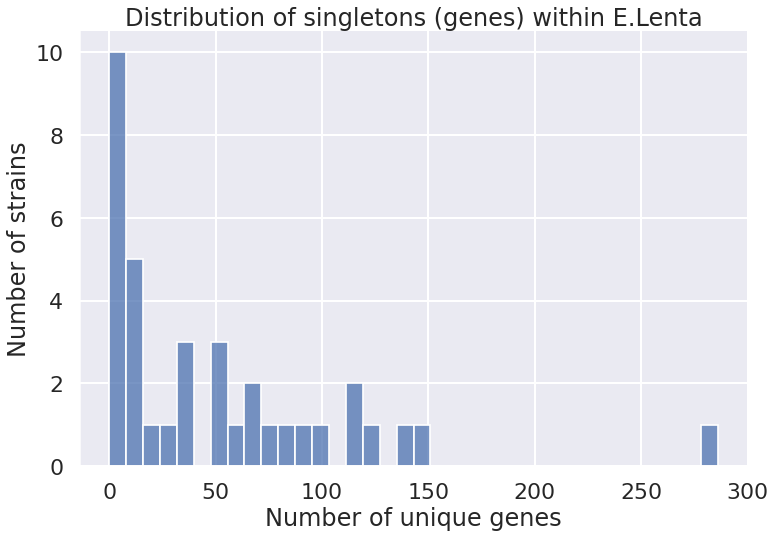

In [6]:
# Try to compare the number of singletons
most_genes=[]
ss = df[(df.sum(axis=1) == 1)] # & (df.sum(axis=1) < 2)]
singletons_freq=ss.sum().sort_values()


plt.figure(figsize=(12,8))
sns.histplot(singletons_freq,bins=36,)
sns.despine()
plt.title('Distribution of singletons (genes) within E.Lenta')
plt.ylabel('Number of strains')
plt.xlabel('Number of unique genes')



Join the dataframes:

To account for kmers has multiple gene hits, aggregate the table using max() to make sure that   
    True + False = True   
    and   
    True + True = True  
max() is also faster than sum and will retain boolean

In [7]:
# Joins the (kmer x gene) with (gene x strain) to return the final (kmer x strain) table
kmerdb: pd.DataFrame = (
    db.reset_index().set_index("gene")
    .join(df)
    .set_index("kmers")
)

# Group similar kmers and add their bool vectors
kmerdb = kmerdb.groupby('kmers').max()

#print(kmerdb.index.is_unique)

kmerdb.head()

,prokka_GCA_000024265.1,prokka_GCA_000763035.1,prokka_GCA_002148255.1,prokka_GCA_003339935.1,prokka_GCA_003339945.1,prokka_GCA_003339975.1,prokka_GCA_003340015.1,prokka_GCA_003340075.1,prokka_GCA_003340105.1,prokka_GCA_003340195.1,...,prokka_GCA_015668635.1,prokka_GCA_015669125.1,prokka_GCA_021378605.1,prokka_GCA_021378625.1,prokka_GCA_021378645.1,prokka_GCA_021378665.1,prokka_GCA_021378685.1,prokka_GCA_021378705.1,prokka_GCA_021378725.1,prokka_GCA_022845935.1
kmers,,,,,,,,,,,,,,,,,,,,,
b'AAAAAAAAGATTCTCCTCTTTAGCAAAAACG',True,False,False,False,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
b'AAAAAAAAGATTCTGGCGACTTGCGCGATGC',True,True,False,False,True,True,False,False,True,False,...,False,False,True,False,False,False,False,True,False,True
b'AAAAAAAAGCTCAAAGGGGATCCATTGGGGT',False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
b'AAAAAAAAGGTCAGTCGACAATCTGAGTCTT',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
b'AAAAAAAATAATTCCCTGCTTTGCTGTCCTC',False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [8]:
# Try to compare the number of singletons
most_genes=[]
singleton_genes = kmerdb[(kmerdb.sum(axis=1) == 1)] # & (df.sum(axis=1) < 2)]
singleton_genes.head()

,prokka_GCA_000024265.1,prokka_GCA_000763035.1,prokka_GCA_002148255.1,prokka_GCA_003339935.1,prokka_GCA_003339945.1,prokka_GCA_003339975.1,prokka_GCA_003340015.1,prokka_GCA_003340075.1,prokka_GCA_003340105.1,prokka_GCA_003340195.1,...,prokka_GCA_015668635.1,prokka_GCA_015669125.1,prokka_GCA_021378605.1,prokka_GCA_021378625.1,prokka_GCA_021378645.1,prokka_GCA_021378665.1,prokka_GCA_021378685.1,prokka_GCA_021378705.1,prokka_GCA_021378725.1,prokka_GCA_022845935.1
kmers,,,,,,,,,,,,,,,,,,,,,
b'AAAAAAAAGGTCAGTCGACAATCTGAGTCTT',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
b'AAAAAAAATCCACTCTCTCAAAAAGAGACTG',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
b'AAAAAAAATTCAAAATCTTTCAGAGAAGCTG',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
b'AAAAAAACACTGTATAGGTGTGGGGTGCGGC',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
b'AAAAAAACAGAGGCTTCGGTAGTTTGTGTGA',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Text(0.5, 0, 'Number of unique genes')

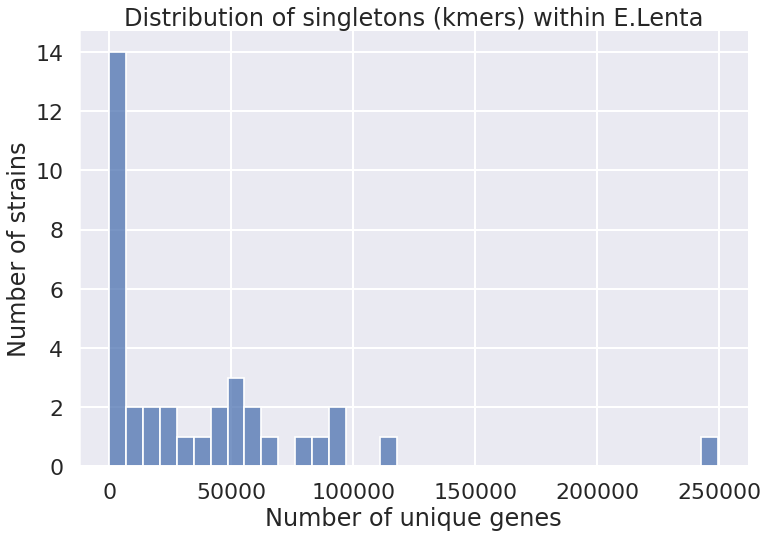

In [9]:
singletons_freq=singleton_genes.sum()#.sort_values()


plt.figure(figsize=(12,8))
sns.histplot(singletons_freq,bins=36,)
sns.despine()
plt.title('Distribution of singletons (kmers) within E.Lenta')
plt.ylabel('Number of strains')
plt.xlabel('Number of unique genes')

In [ ]:
# Count number of kmers added each time

unique_kmers = set()
cumsum_kmers = list()
random_strainorder = random.choices(df.columns,k=len(df.columns)) # Randomly order the strains
for s in random_strainorder:
    unique_kmers.update(df[df[s]].index) # For each strain, add the new k-mers discovered
    cumsum_kmers.append(len(unique_kmers)) # Count number of k-mers discovered after each strain is added


sns.set_context('talk')
plt.figure(figsize=(12,8))
sns.despine()
sns.lineplot(x=np.arange(len(cumsum_kmers)), y=cumsum_kmers,)
plt.title('Cumulative number of k-mers with each strain')
plt.xlabel('Number of genomes added')
plt.ylabel('Number of unique k-mers (millions) ')

Assess the closed/open-ness of the pangenome in k-mer terms

In [ ]:
# Count number of kmers added each time

unique_kmers = set()
cumsum_kmers = list()
random_strainorder = random.choices(kmerdb.columns,k=len(kmerdb.columns)) # Randomly order the strains
for s in random_strainorder:
    unique_kmers.update(kmerdb[kmerdb[s]].index) # For each strain, add the new k-mers discovered
    cumsum_kmers.append(len(unique_kmers)) # Count number of k-mers discovered after each strain is added

sns.set_context('talk')
plt.figure(figsize=(12,8))
sns.despine()
sns.lineplot(x=np.arange(len(cumsum_kmers)), y=cumsum_kmers,)
plt.title('Cumulative number of k-mers with each strain')
plt.xlabel('Number of genomes added')
plt.ylabel('Number of unique k-mers (millions) ')

Distribution of k-mers

Text(0.5, 1.0, 'Distribution of gene types within pangenome')

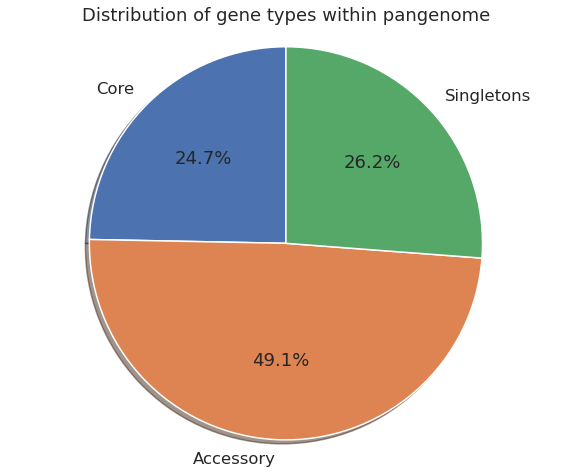

In [11]:

nstrains = 36
total_genes= len(df)

kmer_prevalence = df.sum(axis=1)
core = df[kmer_prevalence == nstrains]
acc = df[(kmer_prevalence > 1) & (kmer_prevalence < nstrains)]
singletons = df[kmer_prevalence == 1]

# % k-mers occupying 1..N strains
#kuniq = []
# for i in range(nstrains+1):
#     pct = len(kmerdb[kmer_prevalence == i]) / total_kmers
#     kuniq.append(pct)
#     print(f"{pct:.2%} of k-mers occur in {i} strains")

sns.set_context('talk')
fig1, ax1 = plt.subplots(figsize=(10,8))
kmer_dist = [len(i) / total_genes for i in [core, acc, singletons]]
labels = ['Core','Accessory','Singletons']
ax1.pie(kmer_dist, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of gene types within pangenome')


Text(0.5, 1.0, 'Distribution of kmer types within pangenome')

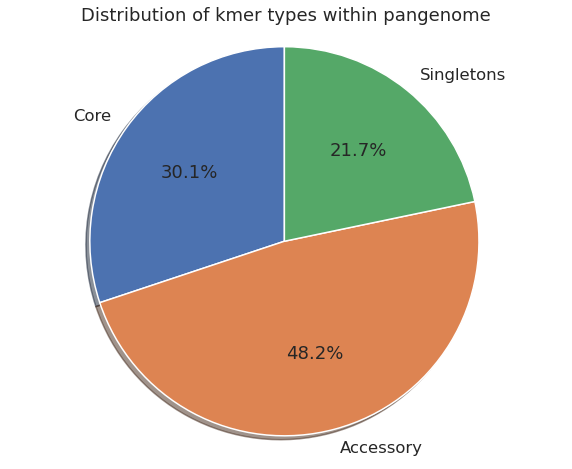

In [9]:
nstrains = 36
total_kmers = len(kmerdb)

kmer_prevalence = kmerdb.sum(axis=1)
core = kmerdb[kmer_prevalence == nstrains]
acc = kmerdb[(kmer_prevalence > 1) & (kmer_prevalence < nstrains)]
singletons = kmerdb[kmer_prevalence == 1]

# % k-mers occupying 1..N strains
#kuniq = []
# for i in range(nstrains+1):
#     pct = len(kmerdb[kmer_prevalence == i]) / total_kmers
#     kuniq.append(pct)
#     print(f"{pct:.2%} of k-mers occur in {i} strains")

sns.set_context('talk')
fig1, ax1 = plt.subplots(figsize=(10,8))
kmer_dist = [len(i) / total_kmers for i in [core, acc, singletons]]
labels = ['Core','Accessory','Singletons']
ax1.pie(kmer_dist, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of kmer types within pangenome')


Make 'type' column

In [10]:
# Label each k-mer according to type
kmerdb['type'] = ''
kmerdb.loc[core.index, 'type'] = 'core'
kmerdb.loc[acc.index, 'type'] = 'accessory'
kmerdb.loc[singletons.index, 'type'] = 'singleton'

### Initial Testing: Let's pretend to sequence a read

Sample some kmers along with some fake 'nullmers' to represent 14 kmers that we retrieved from a read

In [11]:
# Sample some kmers along with some fake 'nullmers' to represent 14 kmers that we retrieved from a read

def make_nullmers(results, n):
    """ Wrapper for multiple null_sequences """

    def make_nullmer():
        # Generate single a fake nullmer

        nullmer = results.iloc[0].copy() 

        # Name stuff
        prefix_letter = random.choice(list(set("ABCDEFGHIJKLSDKJFOIEHFSLADKJF")))
        nullmer.name = (prefix_letter + "D"*30).encode()

        nullmer[:] = False # Doesn't match to any strain
        nullmer["type"] = "unknown" # No type
        return nullmer

    # Generate some nullmers
    nullmers,idx_null = [],[]
    for _ in range(n):
        nmer = make_nullmer()
        nullmers.append(nmer)
        idx_null.append(nmer.name)

    # Return nullmer dataframe
    nulldf = pd.DataFrame(
        index=idx_null, 
        columns=nullmers[0].index, 
        data=nullmers
        )

    return nulldf

fakemers = kmerdb.sample(10)  
nulldf = make_nullmers(fakemers, 5)

results = pd.concat([fakemers, nulldf])
results.head()


,prokka_GCA_000024265.1,prokka_GCA_000763035.1,prokka_GCA_002148255.1,prokka_GCA_003339935.1,prokka_GCA_003339945.1,prokka_GCA_003339975.1,prokka_GCA_003340015.1,prokka_GCA_003340075.1,prokka_GCA_003340105.1,prokka_GCA_003340195.1,...,prokka_GCA_015669125.1,prokka_GCA_021378605.1,prokka_GCA_021378625.1,prokka_GCA_021378645.1,prokka_GCA_021378665.1,prokka_GCA_021378685.1,prokka_GCA_021378705.1,prokka_GCA_021378725.1,prokka_GCA_022845935.1,type
b'AGCCTAGGACGCTCTTGAGCCATGTTCTCGT',True,True,False,False,True,True,False,False,True,False,...,False,True,False,False,False,False,True,False,True,accessory
b'CAGGATCCGAAGGGCGACAGCAAGCAGGCCA',True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,core
b'CGAGCGGACGGAGTTGCGCGAGACGTTGCAG',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,singleton
b'AGTCGGCTGCCATAGCGCCCGACCAGCATAT',True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,accessory
b'GGGACGGTGGCCCTCGGGTTGCGAAGGCTGT',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,accessory


#### 3 options to extract from our annotation data

##### Option 1 - Kmer Type

In [12]:
# Looking at it by prevalence type
print(f" Breakdown by read-type:\n {results['type'].value_counts(dropna=False)}\n")

 Breakdown by read-type:
 accessory    8
unknown      5
core         1
singleton    1
Name: type, dtype: int64



##### Option 2 - Max hits per strain

In [13]:
# Looking at it by hits towards each strain
print( f" Breakdown by overall hits per strain \n {results.select_dtypes('bool').sum().sort_values(ascending=False).head()}")

 Breakdown by overall hits per strain 
 prokka_GCA_015557295.1    6
prokka_GCA_003438525.1    6
prokka_GCA_000763035.1    6
prokka_GCA_002148255.1    5
prokka_GCA_021378605.1    5
dtype: int64


##### Option 3 - Deduce composition using singletons and accessory gene hits

In [14]:
def get_singleton_strain(strain_lists):
    if len(strain_lists) == 1:
        return strain_lists[0]

strain_results = (
    results.apply(lambda row: row[row == True].index, axis=1)
    .apply(get_singleton_strain)
    .dropna()
    # .unique()
)

singleton_candidates = collections.Counter(strain_results.to_list())
print(f"Singleton strain candidates: {strain_results.to_list()}")

Singleton strain candidates: ['prokka_GCA_015554455.1']


Alternate option of ID'ing singletons

In [15]:
# Option 2
def another_singleton_apply(each_row):
    each_row = each_row
    mask = each_row.to_numpy().astype(bool)
    strain_cols = results.columns.to_numpy()
    return strain_cols[mask][:-1]


strain_results = results.apply(another_singleton_apply, axis=1)
strain_results.apply(len).sort_values(ascending=False);

# strain_results[len(strain_results) == 1]
# ll = [list(i) for i in strain_results.to_list()]
# collections.Counter([j for i in ll for j in i]).most_common()

Strain frequency in accessory genes

In [16]:
def get_accessory_strain(strain_lists,nstrains=36):
    if len(strain_lists) > 1 and len(strain_lists) < nstrains:
        return strain_lists

acc_strain_results = (
    results.apply(lambda row: row[row == True].index, axis=1)
    .apply(get_accessory_strain)
    .dropna()
)

# View most common strains with ambiguous hits
acc_strain_results.explode().value_counts().head()



prokka_GCA_000763035.1    5
prokka_GCA_003438525.1    5
prokka_GCA_015557295.1    5
prokka_GCA_015555425.1    4
prokka_GCA_015547345.1    4
dtype: int64

In [17]:
strain_results = results.apply(lambda row: row[row == True].index, axis=1)

def get_singleton_strain(strain_lists):
    if len(strain_lists) == 1:
        return strain_lists[0] 

read_singleton_strains = strain_results.apply(get_singleton_strain).dropna().unique()
read_singleton_strains

# results.apply(lambda row: results.columns[row].index, axis=1)
def another_singleton_apply(each_row):
    each_row = each_row
    mask = each_row.to_numpy().astype(bool)
    strain_cols = results.columns.to_numpy()
    return strain_cols[mask][:-1]

results.apply(another_singleton_apply, axis=1);
#.dropna().unique()
# rc = results.columns.to_numpy()[:-1] 
# rc[mask]


#### Incorporating row + column sums for information

In [18]:
# A toy example with our previous fake results
arr = results[:9].to_numpy()[:,:-1]
row = results.iloc[10].to_numpy()[:-1]
new_arr= np.append(arr,[row],axis=0)


# Column sum and row sum
new_arr.shape # (10,36)
num_kmers = new_arr.shape[0]

hsum = np.sum(new_arr,axis=1) # 10
vsum = np.sum(new_arr,axis=0) # 36

# Find max across each sum
hmax_indices = np.argwhere(vsum == np.max(vsum)).flatten()
vmax_indices = np.argwhere(hsum == np.max(hsum)).flatten()

##### Rowsums for k-mer classification

In [19]:
NSTRAINS = 36
SINGLE = 1


def kmer_typing(kmerdb, NSTRAINS, num_kmers):
    """

    Input:

        kmerdb
            kmer to pangenome spectra
        NSTRAINS
            number of strains
        num_kmers
            number of kmers in a given read

    Processes:

        Create a vector of length num_k = number of kmers.
        Annotate each kmer as 'core, acc, single, or notfound:
            ['c','a','s','x']
    
    Returns:

        ktypes
            vector of length num_k that contains kmer class
        
        singleton_strains
                the source strains of each singleton

        accessory_candidates
                the accumulated accessory hits

        read_stats
            the overall % core,acc,single,etc for a given read 
    
    
    """

    # Initialize
    strains = np.array(kmerdb.columns)
    ktypes = np.empty(num_kmers, dtype="U1")

    # Annotate each k-mer by its hit-type
    ktypes[(hsum == NSTRAINS).nonzero()] = "c"
    ktypes[(hsum == SINGLE).nonzero()] = "s"
    ktypes[((hsum > SINGLE) & (hsum < NSTRAINS)).nonzero()] = "a"
    ktypes[(hsum == 0).nonzero()] = "x"

    # USEFUL Read stats
    singleton_strains = strains[(hsum == SINGLE).nonzero()]
    accessory_candidates = strains[((hsum > SINGLE) & (hsum < NSTRAINS)).nonzero()]
    read_stats = collections.Counter(ktypes)

    return ktypes, singleton_strains, accessory_candidates, read_stats


# example with previous fake result
ktypes, singleton_strains, accessory_candidates, read_stats = kmer_typing( kmerdb, NSTRAINS, new_arr.shape[0])


##### Vertical sums for maximum strain hits

In [20]:
hitrate = vsum / num_kmers # Normalize
strains = kmerdb.columns.to_numpy()
# Determine the strain with most counts
strain_mosthit = strains[np.argwhere(vsum == np.max(vsum)).flatten()]

print(f"The most frequent hits for this read were {strain_mosthit}, each hit by {np.max(hitrate):.2%} of kmers ")

The most frequent hits for this read were ['prokka_GCA_000763035.1'], each hit by 60.00% of kmers 


# Real sample investigation

### K-mer Analysis

In [21]:
### KMER STUFF ###

def count_kmers(gene_sequences,kmerlen=31,ft='fasta'):
    kmers = []
    for record in SeqIO.parse(gene_sequences,ft):
        with memoryview(bytes(record.seq)) as m:
            for k in range(m.nbytes - kmerlen + 1):
                kmer = m[k : k + kmerlen]
                kmers.append(bytes(kmer))
    return kmers


# Count all kmers in file
reads_file = "/hdd/scratch_files/elenta_genomes/genbank/bacteria/fnas/double_dat.fq"
kmerset = count_kmers(reads_file, ft="fastq")

# Get frequency of each kmer
countmers = Counter(kmerset) 

# Distribution of frequencies
kmerdist = Counter(countmers.values()).most_common()
total_kmers = np.sum([v for k,v in kmerdist])

# Show the uniqueness profile
kmerprofile = [round(v*100/total_kmers,2) for k,v in kmerdist]



In [22]:
print(len(kmerset))
print(len(sample_kmers))

57230400


NameError: name 'sample_kmers' is not defined

Plot the kmer distribution

<AxesSubplot:>

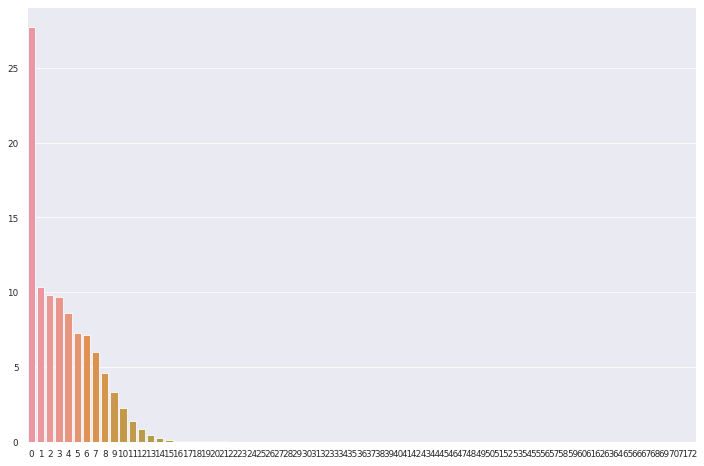

In [ ]:
sns.set_theme()
plt.figure(figsize=(12,8))
sns.set_context('paper')
sns.barplot(x=np.arange(len(kmerprofile)),y=kmerprofile)


### Extract matches in the database

In [ ]:
# Retrieve all kmers from the database, and retain unmapped ones as empty

sample_kmers = pd.DataFrame(index=kmerset)
fetched_kmers = sample_kmers.join(kmerdb,how='left') 


,prokka_GCA_000024265.1,prokka_GCA_000763035.1,prokka_GCA_002148255.1,prokka_GCA_003339935.1,prokka_GCA_003339945.1,prokka_GCA_003339975.1,prokka_GCA_003340015.1,prokka_GCA_003340075.1,prokka_GCA_003340105.1,prokka_GCA_003340195.1,...,prokka_GCA_015669125.1,prokka_GCA_021378605.1,prokka_GCA_021378625.1,prokka_GCA_021378645.1,prokka_GCA_021378665.1,prokka_GCA_021378685.1,prokka_GCA_021378705.1,prokka_GCA_021378725.1,prokka_GCA_022845935.1,type
b'AAAAAAAAAAAAAGCGACCCCGGCACGCTGC',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'AAAAAAAAAAAAAGCGACCCCGGCACGCTGC',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'AAAAAAAAAAAAAGCGACCCCGGCACGCTGC',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'AAAAAAAAAAAAAGCGACCCCGGCACGCTGC',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'AAAAAAAAAAAAAGCGACCCCGGCACGCTGC',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTTTTTTTTTTCACGGTTGCGTACTATATCG',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'TTTTTTTTTTTTCACGGTTGCGTACTATATC',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'TTTTTTTTTTTTCACGGTTGCGTACTATATC',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'TTTTTTTTTTTTTCACGGTTGCGTACTATAT',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

fetched_kmers = fetched_kmers.dropna(how='all')
print(len(fetched_kmers))

22011372


In [ ]:
fetched_kmers

,prokka_GCA_000024265.1,prokka_GCA_000763035.1,prokka_GCA_002148255.1,prokka_GCA_003339935.1,prokka_GCA_003339945.1,prokka_GCA_003339975.1,prokka_GCA_003340015.1,prokka_GCA_003340075.1,prokka_GCA_003340105.1,prokka_GCA_003340195.1,...,prokka_GCA_015669125.1,prokka_GCA_021378605.1,prokka_GCA_021378625.1,prokka_GCA_021378645.1,prokka_GCA_021378665.1,prokka_GCA_021378685.1,prokka_GCA_021378705.1,prokka_GCA_021378725.1,prokka_GCA_022845935.1,type
b'AAAAAAAAGATTCTCCTCTTTAGCAAAAACG',True,False,False,False,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,accessory
b'AAAAAAAAGATTCTCCTCTTTAGCAAAAACG',True,False,False,False,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,accessory
b'AAAAAAAAGATTCTCCTCTTTAGCAAAAACG',True,False,False,False,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,accessory
b'AAAAAAAAGATTCTGGCGACTTGCGCGATGC',True,True,False,False,True,True,False,False,True,False,...,False,True,False,False,False,False,True,False,True,accessory
b'AAAAAAAAGCTCAAAGGGGATCCATTGGGGT',False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,accessory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTTTTTTTGATGGTGAAAACCTCGGTGCAAA',True,False,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,False,True,True,accessory
b'TTTTTTTTGCCTACATCCCTTTGAACATTTC',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,singleton
b'TTTTTTTTGCCTACATCCCTTTGAACATTTC',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,singleton
b'TTTTTTTTGCCTACATCCCTTTGAACATTTC',False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,singleton


### Row and Column Sum Analysis

In [ ]:
# Look for various maxima and patterns here

vsum = np.sum(fetched_kmers,axis=0).to_numpy()
hsum = np.sum(fetched_kmers,axis=1).to_numpy()

print(f"The rowsums are: \n {hsum}")
print(f"The column sums are: \n{vsum}")

print(f"Hsum shape: {hsum.shape}")
print(f"Vsum shape: {vsum.shape}")



### Singleton analysis - Many caveats to this, not likely to be effective due to poor distribution of singleton kmers

In [ ]:
### SINGLETON STUFF ###

SINGLE = 1

singleton_strains = fetched_kmers.iloc[(hsum == SINGLE).nonzero()[0]]

strain_results = (
    singleton_strains.apply(lambda row: row[row == True].index, axis=1)
    .apply(get_singleton_strain)
    .dropna()
    # .unique()
)

print(strain_results.value_counts())


### Accessory Gene hitcount - might work well given the current methods approach

In [ ]:
### ACCESSORY STUFF ###

acc_strains = fetched_kmers.iloc[((hsum > SINGLE) & (hsum < 0.5*NSTRAINS)).nonzero()[0]]

acc_strain_results = (
    acc_strains.apply(lambda row: row[row == True].index, axis=1)
    .apply(get_accessory_strain)
    .dropna()
    .apply(lambda x: x.to_list())
)

# top_acc = Counter([j for i in acc_strains.to_list() for j in i]).most_common()
# print(top_acc)

acc_strain_results

### Ktyping - possibly more useful later

In [ ]:
### KTYPING STUFF ###

num_kmers = len(fetched_kmers)
strains = np.array(kmerdb.columns)
ktypes = np.empty(num_kmers, dtype="U1")
ktypes[(hsum == NSTRAINS).nonzero()[0]] = 'c'
ktypes[(hsum == SINGLE).nonzero()[0]] = "s"
ktypes[((hsum > SINGLE) & (hsum < NSTRAINS)).nonzero()[0]] = "a"
ktypes[(hsum == 0).nonzero()[0]] = "x"

# USEFUL Read stats
# singleton_strains = strains[(hsum == SINGLE).nonzero()[0]]
# accessory_candidates = strains[((hsum > SINGLE) & (hsum < NSTRAINS)).nonzero()]
read_stats = collections.Counter(ktypes)

# strains
read_stats

# Other

Alternate merge thing

In [ ]:
# Equivalent to kmerdb join (fyi)

df_all = db.merge(
    df,
    left_index=True,
    right_index=True,
    how="inner",
    indicator=False,
).set_index("kmers")

df_all.equals(kmerdb)


### This is all later stuff - not db investigation below, per se

In [ ]:
import pickle
with open("/media/mladen/kai/sarc/Strain_Analysis/test_pangenome/raw_scores.pkl",'rb') as ph:
    hits = pickle.load(ph)

dz = pd.DataFrame(hits)
dz.columns = ['reads','hits']
dz = dz.set_index('reads')
dz = pd.DataFrame(index=dz.index, data=dz["hits"].to_list(), columns=['c'+str(i) for i in range(dz['hits'][0].size)])
# dz.sum()
dz.columns = newdf.columns
dz.head()